In [94]:
import numpy as np                                           #For array operations
import matplotlib.pyplot as plt                              #For plotting
from scipy.integrate import solve_ivp                        #For solving ODEs
import os                                                   #For file operations
from scipy.optimize import curve_fit                         #For fitting

## Full ABT model

In [95]:
def ABT_rate_equations(t, y, p_cons, k_A, k_T, k_DP, k_DT, k_B, N_T, p_0,bkr):
        """ Rate equation of the BTD model
        
        :param n_e: CB electron concentration (cm-3)
        :param n_h: VB hole concentration (cm-3)
        :param n_t: trapped electron concentration (cm-3)
        :p_cons: proportionality constant for the PL signal
        :param k_A: Auger recombination rate (cm3ns-1)
        :param k_T: trapping rate (cm3ns-1)
        :param k_B: bimolecular recombination rate (cm3ns-1)
        :param k_DT: detrapping rate (cm3ns-1)
        :param k_DP: depopulation rate (cm3ns-1)
        :param N_T: Trapped electron concentration (cm-3)
        :param p_0: hole concentration (cm-3)
        :param bkr: background rate (cm3ns-1)""" 
        
        n_e, n_t, n_h = y
        
        A = k_A * (n_e * (n_h + p_0)**2 + (n_h + p_0) * n_e**2)
        B = k_B * n_e * (n_h + p_0)
        T = k_T * n_e * (N_T - n_t)
        DT = k_DT * n_t 
        DP = k_DP * n_t * (n_h + p_0)
        
        dne_dt = - A - B - T + DT
        dnt_dt = T - DP - DT
        dnh_dt = -A - B - DP
        
        return [dne_dt, dnt_dt, dnh_dt]
    
def calculate_TRPL_ABT(t, n_0, p_cons, k_A, k_T, k_DP, k_DT, k_B, N_T, p_0, bkr):
    #Solve the ordinary differential equations for the free electron, trapped electron and hole concentrations    
    n = solve_ivp(ABT_rate_equations, (t[0], t[-1]), [n_0, 0, n_0+p_0], args=(p_cons, k_A, k_T, k_DP, k_DT, k_B, N_T, p_0, bkr), method = 'DOP853', t_eval = t)['y']
    # Calculate TRPL signal - n*p as PL proprtional to n^2
    sig = p_cons * abs(n[0]) * abs(n[2]) + bkr

    return np.log10(sig)

## TRPL Signal ABT model

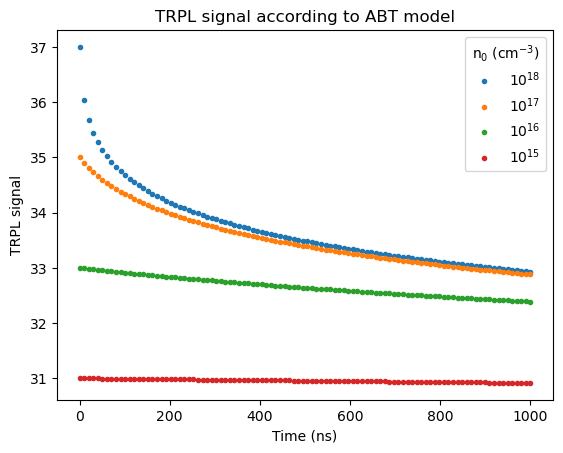

In [96]:
n_0s = [18,17,16,15]
t= np.linspace(0, 1000, 100)
p_cons = 1
k_A = -37
k_T = -19
k_DP = -20
k_DT = -1
k_B = -19
N_T = 15
p_0 = 13
bkr = 1

sigs = []
for n_0 in n_0s:
    sig = calculate_TRPL_ABT(t, 10**n_0, 10**p_cons, 10**k_A, 10**k_T, 10**k_DP,10**k_DT, 10**k_B, 10**N_T, 10**p_0, bkr)
    plt.plot(t,sig,'.',label=f'10$^{{{n_0}}}$')
    #plt.yscale('log')
    #plt.xscale('log')
    plt.legend(title = f'n$_0$ (cm$^{{-3}}$)')
    plt.title('TRPL signal according to ABT model')
    plt.xlabel('Time (ns)')
    plt.ylabel('TRPL signal')
    sigs.append(sig)

### Ensure I can fit to the simulated data

c:\Users\bail2.BLUE\AppData\Local\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Fitted parameters: [1.e+18 1.e+01 1.e-37 1.e-19 1.e-20 1.e-01 1.e-19 1.e+15 1.e+13 1.e+00]
Fitted parameters: [1.e+17 1.e+01 1.e-37 1.e-19 1.e-20 1.e-01 1.e-19 1.e+15 1.e+13 1.e+00]
Fitted parameters: [1.e+16 1.e+01 1.e-37 1.e-19 1.e-20 1.e-01 1.e-19 1.e+15 1.e+13 1.e+00]
Fitted parameters: [1.e+15 1.e+01 1.e-37 1.e-19 1.e-20 1.e-01 1.e-19 1.e+15 1.e+13 1.e+00]


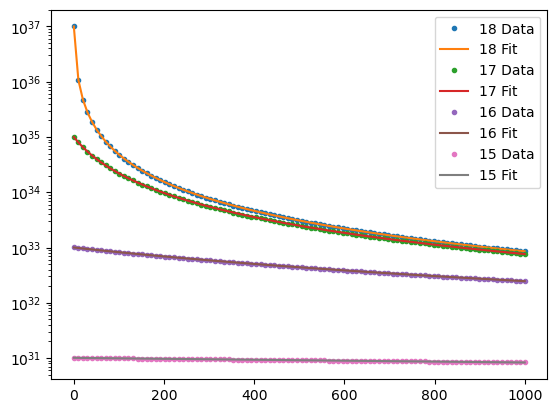

In [97]:
for sig, n in zip(sigs, n_0s):
    # Prepare the data
    time = t
    signal = sig

    # Set the initial parameter guesses
    p0 = np.array((10**n, 10**p_cons, 10**k_A, 10**k_T, 10**k_DP, 10**k_DT, 10**k_B, 10**N_T, 10**p_0, bkr))

    # Perform the curve fit
    popt, pcov = curve_fit(calculate_TRPL_ABT, time, signal, p0=p0, maxfev=10000)

    # Print the fitted parameters
    print(f"Fitted parameters: {popt}")

    # Plot the results
    plt.plot(time, 10**signal, '.', label=f'{n} Data')
    plt.plot(time, 10**(calculate_TRPL_ABT(time, *popt)), label=f'{n} Fit')
    plt.yscale('log')
    plt.legend()
    

## Try to fit to real data

In [98]:
film_files = [f for f in os.listdir('MAPI_230424_Sorted/') if f.endswith('.npy')and 'FILM' in f]
c60_files = [f for f in os.listdir('MAPI_230424_Sorted/') if f.endswith('.npy')and 'C60' in f]
fluences = [7.1e17, 7.1e+16, 7.1e+15]
print(film_files)
print(c60_files)
print(fluences)

['iCCD_MAPI_2706_150uW_FILM.npy', 'iCCD_MAPI_2706_15uW_FILM.npy', 'iCCD_MAPI_2706_1p5uW_FILM.npy']
['iCCD_MAPI_2706_150uW_C60.npy', 'iCCD_MAPI_2706_15uW_C60.npy', 'iCCD_MAPI_2706_1p5uW_C60.npy']
[7.1e+17, 7.1e+16, 7100000000000000.0]


### Fitting parameters according to https://doi.org/10.1039/D0CP04950F and https://doi.org/10.17863/CAM.6537

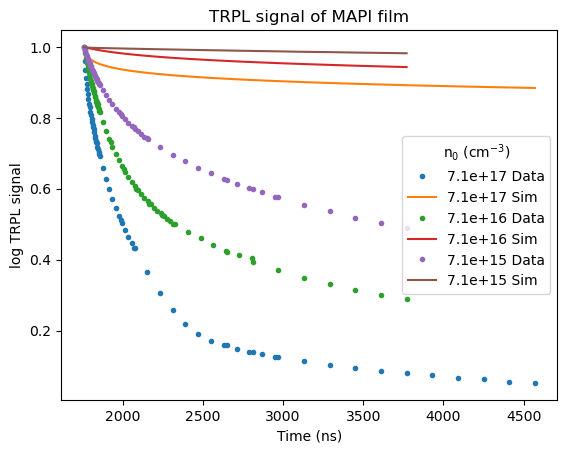

In [105]:
film_datas = []

k_A = -37
k_T = -17
k_DP = -19.5
k_DT = -18
k_B = -19.3
N_T = 15
p_0 = 13
bkr = 1

    
    
for file,fluence in zip(film_files,fluences):
    
    data = np.load('MAPI_230424_Sorted/'+file)
    film_datas.append(data)
    time = data[0]
    
    signal = np.log10(data[1])
    p_cons = signal[0]/fluence**2 #conversion factor shouldnt actually matter if this is all normalised
    
    sim_sig = calculate_TRPL_ABT(data[0], fluence, 10**p_cons, 10**k_A, 10**k_T, 10**k_DP,10**k_DT, 10**k_B, 10**N_T, 10**p_0, bkr) #calculated simulated signal
    
    plt.plot(data[0], np.log10(data[1])/np.log10(data[1][0]), '.', label=f'{fluence:.1e} Data') # normalised data
    plt.plot(data[0],sim_sig/sim_sig[0], label=f'{fluence:.1e} Sim')                            # normalised simulated signal
    
    #plt.yscale('log')
    plt.legend(title = f'n$_0$ (cm$^{{-3}}$)')
    plt.title('TRPL signal of MAPI film')
    plt.xlabel('Time (ns)')
    plt.ylabel('log TRPL signal')
plt.show()


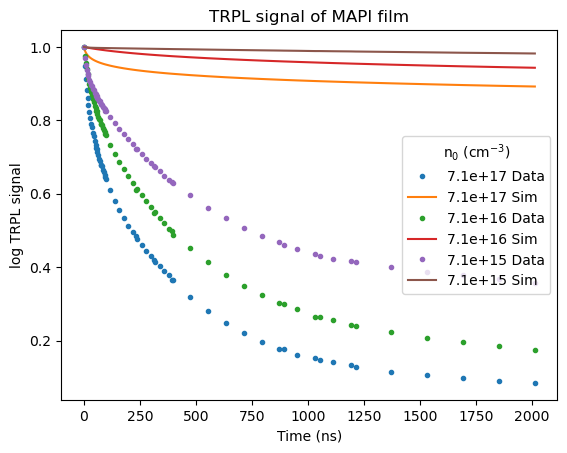

In [100]:
c60_datas = []
    
k_A = -37
k_T = -17
k_DP = -19.5
k_DT = -18
k_B = -19.3
N_T = 15
p_0 = 13
bkr = 1

    
    
for file,fluence in zip(c60_files,fluences):
    
    data = np.load('MAPI_230424_Sorted/'+file)
    c60_datas.append(data)
    time = data[0] - data[0][0]
    signal = np.log10(data[1])
    p_cons = signal[0]/fluence**2 #conversion factor shouldnt actually matter if this is all normalised
    
    sim_sig = calculate_TRPL_ABT(time, fluence, 10**p_cons, 10**k_A, 10**k_T, 10**k_DP,10**k_DT, 10**k_B, 10**N_T, 10**p_0, bkr) #calculated simulated signal
    
    plt.plot(time, signal/signal[0], '.', label=f'{fluence:.1e} Data') # normalised data
    plt.plot(time,sim_sig/sim_sig[0], label=f'{fluence:.1e} Sim')                            # normalised simulated signal
    
    #plt.yscale('log')
    plt.legend(title = f'n$_0$ (cm$^{{-3}}$)')
    plt.title('TRPL signal of MAPI film')
    plt.xlabel('Time (ns)')
    plt.ylabel('log TRPL signal')
plt.show()

In [104]:
# for data,fluence in zip(film_datas, fluences):
#     time = data[0] #time in ns
#     signal = data[1]/data[1][0] #normalised signal

#     p_cons = signal[0]/fluence**2 #conversion factor shouldnt actually matter if this is all normalised
#     # Set the initial parameter guesse
#     p0 = [10**n, 10**p_cons, 10**k_A, 10**k_T, 10**k_DP, 10**k_DT, 10**k_B, 10**N_T, 10**p_0, bkr]

#     # Perform the curve fit
#     print(time.shape)
#     print(signal.shape)
#     popt, pcov = curve_fit(calculate_TRPL_ABT, time, np.log10(signal), p0=p0, maxfev=10000)

#     # Print the fitted parameters
#     print(f"Fitted parameters: {popt}")

#     # Plot the results
#     plt.plot(time, np.log10(signal)/np.log10(signal[0]), '.', label=f'{n} Data')
#     sim_sig = calculate_TRPL_ABT(data[0], *abs(popt))
#     plt.plot(time, sim_sig/sim_sig[0], label=f'{n} Fit')

#     #plt.yscale('log')
#     plt.show()


In [103]:
# for data,fluence in zip(film_datas, fluences):
#     time = data[0]-data[0][0] #time in ns
#     signal = data[1] 
#     p_cons = signal[0]/fluence**2 #conversion factor shouldnt actually matter if this is all normalised
#     # Set the initial parameter guesse
#     p0 = [10**n, 10**p_cons, 10**k_A, 10**k_T, 10**k_DP, 10**k_DT, 10**k_B, 10**N_T, 10**p_0, bkr]

#     # Perform the curve fit
#     popt, pcov = curve_fit(calculate_TRPL_ABT, time, signal, p0=p0, maxfev=10000)

#     # Print the fitted parameters
#     print(f"Fitted parameters: {popt}")

#     # Plot the results
#     plt.plot(time, np.log10(signal)/np.log10(signal[0]), '.', label=f'{n} Data')
#     sim_sig = calculate_TRPL_ABT(data[0], *abs(popt))
#     plt.plot(time, sim_sig/sim_sig[0], label=f'{n} Fit')

#     plt.yscale('log')
# plt.show()